In [1]:
import os, zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
from google.colab import drive

# ÊéõËºâ Google Drive
drive.mount('/content/drive', force_remount=True)

# Ëß£Â£ìÁ∏ÆË≥áÊñô
zip_path = '/content/drive/MyDrive/face_glasses.zip'
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_path = '/content/face_glasses/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

class_names = train_dataset.class_names
positive_idx = class_names.index("positive")
negative_idx = class_names.index("negative")

train_all = list(train_dataset.unbatch())
positive_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == positive_idx]
negative_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == negative_idx]

# Âª∫Á´ã VAE Ë®ìÁ∑¥Ë≥áÊñôÈõÜÔºàÂè™Áî®ÁÑ°ÁúºÈè°Ôºâ
vae_train_dataset = tf.data.Dataset.from_tensor_slices([x for x, _ in negative_train])
vae_train_dataset = vae_train_dataset.map(lambda x: x / 255.0)
vae_train_dataset = vae_train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# È©óË≠âÈõÜÔºöpositive Ë≥áÊñôÂ§æ
val_path = '/content/face_glasses/validation/positive'
vae_val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels=None,
    label_mode=None,
    batch_size=1,
    image_size=IMG_SIZE,
    shuffle=False
).map(lambda x: x / 255.0)

print(f"‚úÖ Ë®ìÁ∑¥Ë≥áÊñôÈáèÔºàÁÑ°ÁúºÈè°Ôºâ: {len(negative_train)}")
print(f"‚úÖ È†êË¶ΩÊ®£Êú¨ÔºàÊúâÁúºÈè°Ôºâ: {len(positive_train)}")

Found 141 files belonging to 2 classes.
Found 20 files.
‚úÖ Ë®ìÁ∑¥Ë≥áÊñôÈáèÔºàÁÑ°ÁúºÈè°Ôºâ: 81
‚úÖ È†êË¶ΩÊ®£Êú¨ÔºàÊúâÁúºÈè°Ôºâ: 60


In [15]:
# ÂÆöÁæ© Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 128

# Encoder
encoder_inputs = keras.Input(shape=(160, 160, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(20 * 20 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((20, 20, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_4       ‚îÇ (None, 160, 160,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_8 (Conv2D)   ‚îÇ (None, 80, 80,    ‚îÇ        896 ‚îÇ input_layer_4[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 80, 80,    ‚îÇ        128 ‚îÇ conv2d_8[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)   ‚îÇ (None, 40, 40,    ‚îÇ     18,496 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 40, 40,    ‚îÇ        256 ‚îÇ conv2d_9[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_10 (Conv2D)  ‚îÇ (None, 20, 20,    ‚îÇ     73,856 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 128)              ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 20, 20,    ‚îÇ        512 ‚îÇ conv2d_10[0][0]   ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 128)              ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten) ‚îÇ (None, 51200)     ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)     ‚îÇ (None, 256)       ‚îÇ 13,107,456 ‚îÇ flatten_3[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 13,267,392 (50.61 MB)

 Trainable params: 13,266,944 (50.61 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_5 (InputLayer)      ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 51200)          ‚îÇ     6,604,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ reshape_1 (Reshape)             ‚îÇ (None, 20, 20, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_3              ‚îÇ (None, 40, 40, 128)    ‚îÇ       147,584 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_4              ‚îÇ (None, 80, 80, 64)     ‚îÇ        73,792 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_5              ‚îÇ (None, 160, 160, 32)   ‚îÇ        18,464 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_9           ‚îÇ (None, 160, 160, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_11 (Conv2D)              ‚îÇ (None, 160, 160, 3)    ‚îÇ           867 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,845,635 (26.11 MB)

 Trainable params: 6,845,571 (26.11 MB)

 Non-trainable params: 64 (256.00 B)

In [4]:
def build_discriminator(input_shape=(160, 160, 3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, x, name="discriminator")

# ÈÄôÊ®£Â∞±ÊúÉÊúâ‰∏ÄÂÄã Discriminator ‰∫Ü
discriminator = build_discriminator()


In [5]:

from tensorflow.keras import backend as K

class VAEGAN(keras.Model):
    def __init__(self, encoder, decoder, discriminator, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.gan_loss_tracker = keras.metrics.Mean(name="gan_loss")

        self.kl_weight = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.gan_weight = tf.Variable(1.0, trainable=False, dtype=tf.float32)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.gan_loss_tracker,
        ]

    def compile(self, vae_optimizer, disc_optimizer):
        super().compile()
        self.vae_optimizer = vae_optimizer
        self.disc_optimizer = disc_optimizer
        self.bce_loss = keras.losses.BinaryCrossentropy(from_logits=False)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape(persistent=True) as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction)

            disc_loss = self.bce_loss(tf.ones_like(real_output), real_output) +                         self.bce_loss(tf.zeros_like(fake_output), fake_output)

            gan_loss = self.bce_loss(tf.ones_like(fake_output), fake_output)

            total_vae_loss = recon_loss + self.kl_weight * kl_loss + self.gan_weight * gan_loss

        grads = tape.gradient(total_vae_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.vae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))

        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        self.total_loss_tracker.update_state(total_vae_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.gan_loss_tracker.update_state(gan_loss)

        return {
            "total_vae_loss": total_vae_loss,
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "gan_loss": self.gan_loss_tracker.result(),
            "disc_loss": disc_loss,
            "kl_weight": K.get_value(self.kl_weight),
            "gan_weight": K.get_value(self.gan_weight),
        }


In [6]:
# Âª∫Á´ã VAEGAN
vaegan = VAEGAN(encoder, decoder, discriminator)

# ÂàÜÂà•Ë®≠ÂÆöÂÖ©ÂÄã optimizer
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-4)
disc_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

vaegan.compile(
    vae_optimizer=vae_optimizer,
    disc_optimizer=disc_optimizer
)


üöÇ ÈñãÂßãË®ìÁ∑¥ 50 epochs... Ë´ãÁ®çÂÄôÔΩû
Epoch 1/50
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 129ms/step - disc_loss: 1.3130 - gan_loss: 0.7127 - gan_weight: 1.0000 - kl_loss: 0.2412 - kl_weight: 0.0000e+00 - reconstruction_loss: 4539.4634 - total_loss: 4540.1758 - total_vae_loss: 4815.2485
Epoch 2/50
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 136ms/step - disc_loss: 1.1249 - gan_loss: 0.9055 - gan_weight: 1.0000 - kl_loss: 2.3002 - kl_weight: 0.0000e+00 - reconstruction_loss: 4530.5454 - total_loss: 4531.4512 - total_vae_loss: 4806.2070
Epoch 3/50
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 108ms/step - disc_loss: 0.9308 - gan_loss: 0.9938 - gan_weight: 1.0000 - kl_loss: 9.5806 - kl_weight: 0.0000e+00 - reconstruction_loss: 4520.7002 - total_loss: 4521.6938 - total_vae_loss: 4795.9272
Epoch 4/50
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 110ms/step - disc_loss: 0.7383 - gan_loss: 1.

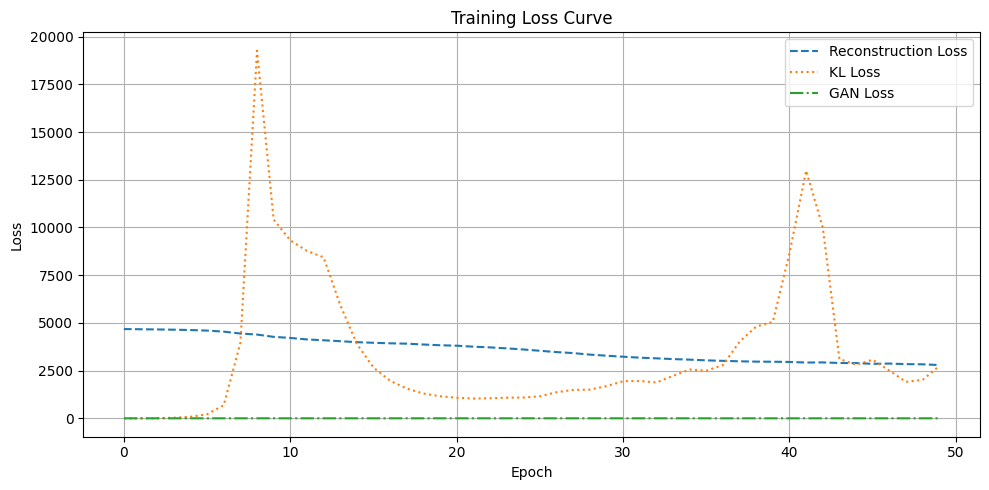

üéØ ÂÆåÊàêÔºÅ


In [7]:
import matplotlib.pyplot as plt

def train_and_plot(model, dataset, epochs=50):
    """
    Âπ´‰Ω†Ë®ìÁ∑¥Ê®°Âûã‰∏¶‰∏îËá™ÂãïÁï´Âá∫ loss Êõ≤Á∑ö„ÄÇ

    Args:
        model: VAE Êàñ VAEGAN È°ûÂûãÁöÑ keras.Model
        dataset: tf.data.Dataset (Ëº∏ÂÖ•Ë≥áÊñô)
        epochs: Ë®ìÁ∑¥ÂπæÂÄã epoch
    """
    if model is None or dataset is None:
        print("‚ùó Ë´ãÂÖàÁ¢∫ÂÆö model Âíå dataset ÈÉΩÊúâÊ≠£Á¢∫Âª∫Á´ãÔºÅ")
        return

    print(f"üöÇ ÈñãÂßãË®ìÁ∑¥ {epochs} epochs... Ë´ãÁ®çÂÄôÔΩû")
    history = model.fit(dataset, epochs=epochs)

    print(f"‚úÖ Ë®ìÁ∑¥ÂÆåÊàêÔºåÈñãÂßãÁï´ loss Êõ≤Á∑ö")

    plt.figure(figsize=(10, 5))
    if "loss" in history.history:
        plt.plot(history.history["loss"], label="Total Loss", linewidth=2)
    if "reconstruction_loss" in history.history:
        plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss", linestyle="--")
    if "kl_loss" in history.history:
        plt.plot(history.history["kl_loss"], label="KL Loss", linestyle=":")
    if "gan_loss" in history.history:
        plt.plot(history.history["gan_loss"], label="GAN Loss", linestyle="-.")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("üéØ ÂÆåÊàêÔºÅ")

    return history



history = train_and_plot(vaegan, vae_train_dataset, epochs=50)

In [8]:
def show_reconstructions(img_dir, encoder, decoder, num_pairs=8, img_size=(160, 160), save_path=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import random

    assert num_pairs % 4 == 0, "num_pairs must be a multiple of 4 for 4-column layout"

    files = os.listdir(img_dir)
    sample_files = random.sample(files, num_pairs)

    cols = 4  # ÊØèÂàó 4 ÁµÑ
    rows = num_pairs // cols  # ÂπæÂàóÁµÑÂúñ

    fig, axs = plt.subplots(rows * 2, cols, figsize=(cols * 2, rows * 5))
    plt.subplots_adjust(hspace=0.4)  # ‰∏ä‰∏ãÈñìË∑ùÂä†Â§ß

    for i, file in enumerate(sample_files):
        img = Image.open(os.path.join(img_dir, file)).resize(img_size)
        img = np.array(img).astype("float32") / 255.0
        img_batch = np.expand_dims(img, axis=0)

        z_mean, z_log_var, z = encoder.predict(img_batch, verbose=0)
        reconstructed = decoder.predict(z, verbose=0)

        row = (i // cols) * 2      # ÊØèÁµÑ‰ΩîÂÖ©Êéí
        col = i % cols

        axs[row, col].imshow(img)
        axs[row, col].set_title("With glasses", fontsize=16)
        axs[row, col].axis("off")

        axs[row + 1, col].imshow(np.clip(reconstructed[0], 0, 1))
        axs[row + 1, col].set_title("No glasses", fontsize=16)
        axs[row + 1, col].axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

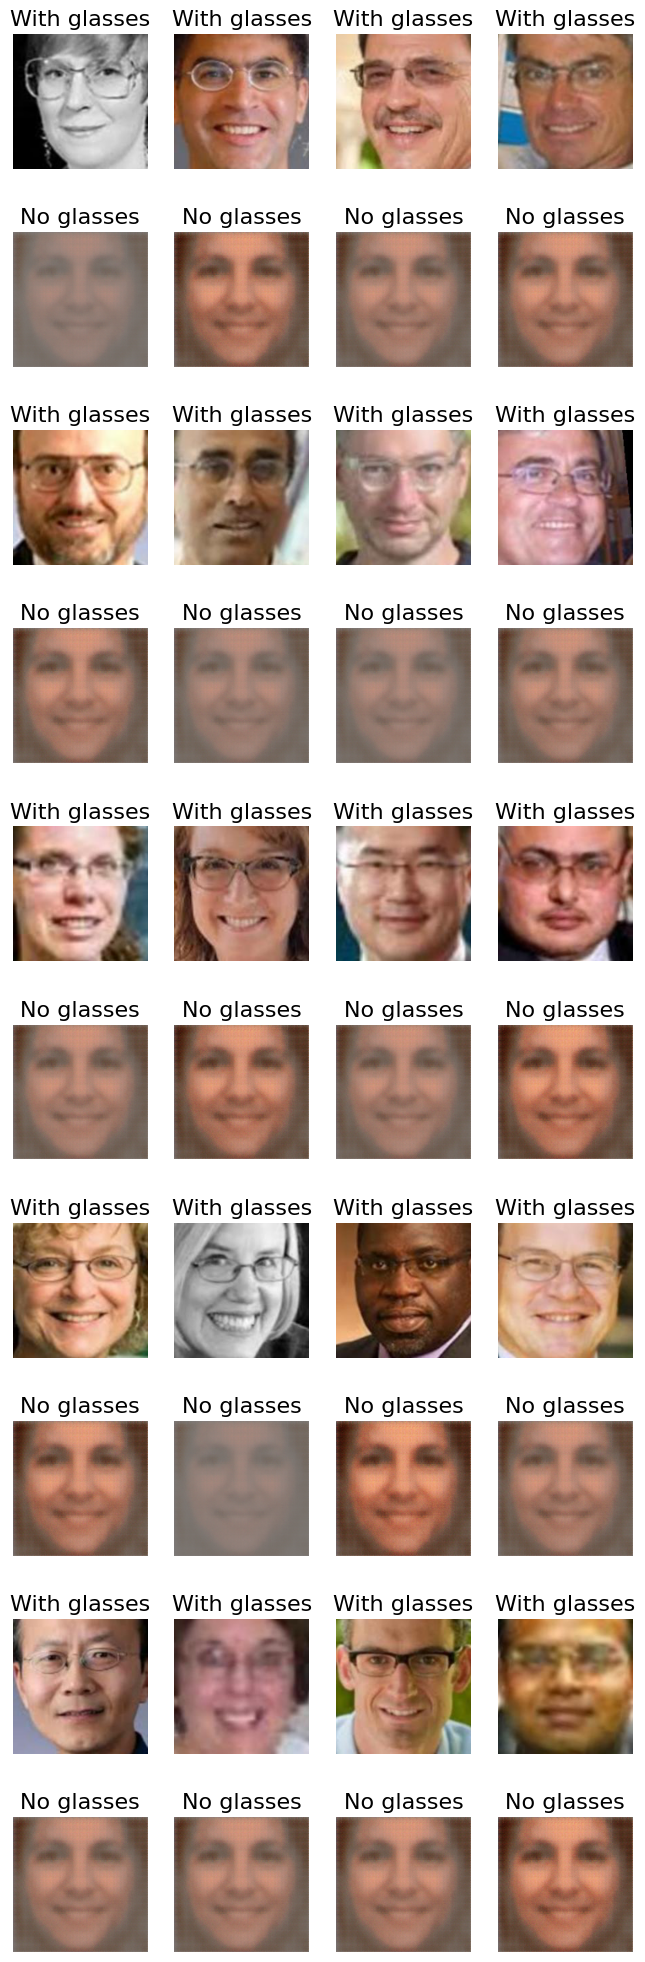

In [9]:
show_reconstructions(
    img_dir="/content/face_glasses/validation/positive",
    encoder=encoder,
    decoder=decoder,
    num_pairs=20
)


In [10]:

# ÂÆöÁæ©Âà§Âà•Âô®ÔºàDiscriminatorÔºâ
def build_discriminator():
    model = keras.Sequential([
        Input(shape=(160, 160, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer=keras.optimizers.Adam(1e-4),
                      loss="binary_crossentropy")


In [11]:

# ÂÆöÁæ©Â∞çÊäóÊêçÂ§±ËàáË®ìÁ∑¥Ê≠•È©ü
bce = keras.losses.BinaryCrossentropy()

@tf.function
def train_step(real_images):
    # 1. Á∑®Á¢ºËàáËß£Á¢ºÔºàVAEÔºâ
    z_mean, z_log_var, z = encoder(real_images)
    reconstructed = decoder(z)

    # 2. Ë®àÁÆó VAE Loss
    reconstruction_loss = tf.reduce_mean(tf.square(real_images - reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss

    # 3. Â∞çÊäóÈÉ®ÂàÜ
    fake_preds = discriminator(reconstructed)
    real_preds = discriminator(real_images)

    # - Discriminator loss
    d_loss_real = bce(tf.ones_like(real_preds), real_preds)
    d_loss_fake = bce(tf.zeros_like(fake_preds), fake_preds)
    d_loss = (d_loss_real + d_loss_fake) / 2

    # - Generator (VAE) ÊÉ≥È®ôÈÅé Discriminator
    adv_loss = bce(tf.ones_like(fake_preds), fake_preds)
    total_g_loss = vae_loss + 0.1 * adv_loss  # 0.1 ÊòØ adversarial loss ÁöÑÊ¨äÈáç

    # 4. Apply gradients
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        # ÂâçÈù¢Â∑≤Á∂ìË®àÁÆó lossÔºå‰∏çÈáçË§á forward
        pass

    grads_g = tape_g.gradient(total_g_loss, encoder.trainable_weights + decoder.trainable_weights)
    grads_d = tape_d.gradient(d_loss, discriminator.trainable_weights)

    optimizer.apply_gradients(zip(grads_g, encoder.trainable_weights + decoder.trainable_weights))
    discriminator.optimizer.apply_gradients(zip(grads_d, discriminator.trainable_weights))

    return reconstruction_loss, kl_loss, adv_loss, d_loss


In [12]:

# ÊØèÂÄã epoch Ë™øÊï¥ KL Ê¨äÈáç
def update_kl_weight(epoch, model, max_kl_weight=1.0, warmup_epochs=10):
    weight = min(max_kl_weight, epoch / warmup_epochs)
    model.kl_weight.assign(weight)
    print(f"‚Üí KL weight: {model.kl_weight.numpy():.4f}")


In [13]:

def plot_loss_curve(history, title="Training Loss Curve"):
    def extract(key):
        return [x.get(key, None) for x in history]

    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(extract("total_vae_loss"), label="Total Loss")
    ax1.plot(extract("reconstruction_loss"), label="Reconstruction Loss", linestyle='--')
    ax1.plot(extract("kl_loss"), label="KL Loss", linestyle=':')
    ax1.plot(extract("gan_loss"), label="GAN Loss", linestyle='-.')
    ax1.plot(extract("disc_loss"), label="Discriminator Loss", linestyle='dotted')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"{title} - Training")
    ax1.legend(loc='upper right')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(extract("kl_weight"), label="KL Weight", color="purple", linestyle='--')
    ax2.set_ylabel("KL Weight")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [14]:

def train_and_plot(model, dataset, epochs=50):
    history = []

    for epoch in range(epochs):
        print(f"üöÇ Epoch {epoch + 1}/{epochs}")
        update_kl_weight(epoch, model)

        for step, batch in enumerate(dataset):
            logs = model.train_on_batch(batch)

        history.append({k: float(v) for k, v in logs.items()})
    plot_loss_curve(history)
    return history
